In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
import seaborn as sns
import matplotlib.pyplot as plt

df=pd.read_csv('../data/raw/bank/bank-full.csv',sep=';')
df

# ✅ Convert 'y' to Numeric
df['y'] = df['y'].map({'yes': 1, 'no': 0})
df['y'] = pd.to_numeric(df['y'], errors='coerce')

# ✅ Define Treatment - Loan Feature
df['treatment'] = df['loan'].map({'yes': 1, 'no': 0})  # 1 = has loan, 0 = no loan

# ✅ Drop Rows with Missing Treatment or Outcome Values
df = df.dropna(subset=['treatment', 'y'])

# ✅ Print Treatment Distribution
print("Treatment Distribution:")
print(df['treatment'].value_counts())


Treatment Distribution:
treatment
0    37967
1     7244
Name: count, dtype: int64


In [2]:
# ✅ Drop Target and Treatment Columns from Features
X = df.drop(columns=['y', 'treatment', 'loan'])

# ✅ Convert Categorical Variables into Dummies
X = pd.get_dummies(X, drop_first=True)

# ✅ Standardize Numerical Features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# ✅ Check for Missing Values in Features
print("Missing values in X_scaled:", np.isnan(X_scaled).sum())

# ✅ Replace NaN Values with Zero (if any exist)
X_scaled = np.nan_to_num(X_scaled)


Missing values in X_scaled: 0


In [3]:
# ✅ Fit Logistic Regression Model for Propensity Score Estimation
logreg = LogisticRegression(solver='saga', max_iter=5000)  # Increased max_iter
logreg.fit(X_scaled, df['treatment'])  # Train Model

# ✅ Compute Propensity Scores
df['propensity_score_loan'] = logreg.predict_proba(X_scaled)[:, 1]

# ✅ Print Sample Propensity Scores
print("Propensity Score Min:", df['propensity_score_loan'].min())
print("Propensity Score Max:", df['propensity_score_loan'].max())

# ✅ Drop Extreme Propensity Scores (Avoid Division Errors)
df = df[(df['propensity_score_loan'] > 0) & (df['propensity_score_loan'] < 1)]


Propensity Score Min: 1.1379216923489543e-07
Propensity Score Max: 0.7687878003120124


In [4]:
df['propensity_score_loan'] = np.clip(df['propensity_score_loan'], 0.01, 0.99)


In [5]:
df['weights'] = df['treatment'] / df['propensity_score_loan'] + \
                (1 - df['treatment']) / (1 - df['propensity_score_loan'])

treated_mean = np.average(df[df['treatment'] == 1]['y'], weights=df[df['treatment'] == 1]['weights'])
control_mean = np.average(df[df['treatment'] == 0]['y'], weights=df[df['treatment'] == 0]['weights'])

ATE_weighted = treated_mean - control_mean
print("ATE (Overall Effect of Loan on Subscription Likelihood):", ATE_weighted)


ATE (Overall Effect of Loan on Subscription Likelihood): -0.031167897867032057


In [6]:
# ✅ Clip propensity scores to avoid extreme values
df['propensity_score_loan'] = np.clip(df['propensity_score_loan'], 0.01, 0.99)

# ✅ Compute inverse probability weights for ATT
df['weights_att'] = (1 - df['treatment']) / (1 - df['propensity_score_loan'])

# ✅ Compute expected outcomes
treated_mean = df[df['treatment'] == 1]['y'].mean()  # E[Y(1) | T=1]
control_mean_weighted = np.average(df[df['treatment'] == 0]['y'], weights=df[df['treatment'] == 0]['weights_att'])  # E[Y(0) | T=1]

# ✅ Compute ATT
ATT = treated_mean - control_mean_weighted
print("ATT (Effect of Loan on Subscription Likelihood for Treated Group):", ATT)


ATT (Effect of Loan on Subscription Likelihood for Treated Group): -0.053655572815392294


In [4]:
import pandas as pd
import numpy as np

# ✅ Step 1: Convert 'y' to Numeric (if not already)
df['y'] = df['y'].map({'yes': 1, 'no': 0})
df['y'] = pd.to_numeric(df['y'], errors='coerce')

# ✅ Step 2: Remove extreme propensity scores (Avoid division errors)
df = df[(df['propensity_score_loan'] > 0) & (df['propensity_score_loan'] < 1)]

# ✅ Step 3: Drop NaN values in 'y'
df = df.dropna(subset=['y'])

# ✅ Step 4: Compute Inverse Probability Weights (IPW)
df['weights'] = df['treatment'] / df['propensity_score_loan'] + \
                (1 - df['treatment']) / (1 - df['propensity_score_loan'])

# ✅ Step 5: Compute ATE (Weighted Difference in Means)
ATE_weighted = (df[df['treatment'] == 1]['y'] * df[df['treatment'] == 1]['weights']).mean() - \
               (df[df['treatment'] == 0]['y'] * df[df['treatment'] == 0]['weights']).mean()

print("ATE (Overall Effect of Loan on Subscription Likelihood):", ATE_weighted)


ATE (Overall Effect of Loan on Subscription Likelihood): nan


In [5]:
print(df.shape)


(0, 20)


In [8]:
# ✅ Separate Treated & Control Groups
treated = df[df['treatment'] == 1].copy()
control = df[df['treatment'] == 0].copy()

# ✅ Fit Nearest Neighbors Model on Control Group
nn = NearestNeighbors(n_neighbors=3, metric='euclidean')  # Use 3 Neighbors
nn.fit(control[['propensity_score_loan']])

# ✅ Find the Nearest Match for Each Treated Unit
distances, indices = nn.kneighbors(treated[['propensity_score_loan']])

# ✅ Get Matched Control Samples
matched_control = control.iloc[indices.flatten()].copy()

# ✅ Create a Balanced Dataset
balanced_df = pd.concat([treated, matched_control])

# ✅ Print Group Sizes
print("Treated Group Size:", balanced_df[balanced_df['treatment'] == 1].shape[0])
print("Control Group Size:", balanced_df[balanced_df['treatment'] == 0].shape[0])


Treated Group Size: 7244
Control Group Size: 21732


In [ ]:
# ✅ Compute Inverse Probability Weights
df['weights'] = df['treatment'] / df['propensity_score_loan'] + \
                (1 - df['treatment']) / (1 - df['propensity_score_loan'])

# ✅ Print Weight Distribution (Check for Extremes)
print("Weight Distribution Summary:")
print(df['weights'].describe())

# ✅ Compute ATE (Weighted Difference in Means)
ATE_weighted = (df[df['treatment'] == 1]['y'] * df[df['treatment'] == 1]['weights']).mean() - \
               (df[df['treatment'] == 0]['y'] * df[df['treatment'] == 0]['weights']).mean()

print("ATE (Overall Effect of Loan on Subscription Likelihood):", ATE_weighted)


Weight Distribution Summary:
count    45211.000000
mean         2.059484
std          8.563085
min          1.000000
25%          1.113938
50%          1.183678
75%          1.350005
max       1512.902413
Name: weights, dtype: float64
ATE (Overall Effect of Loan on Subscription Likelihood): 0.42201611194800154


/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


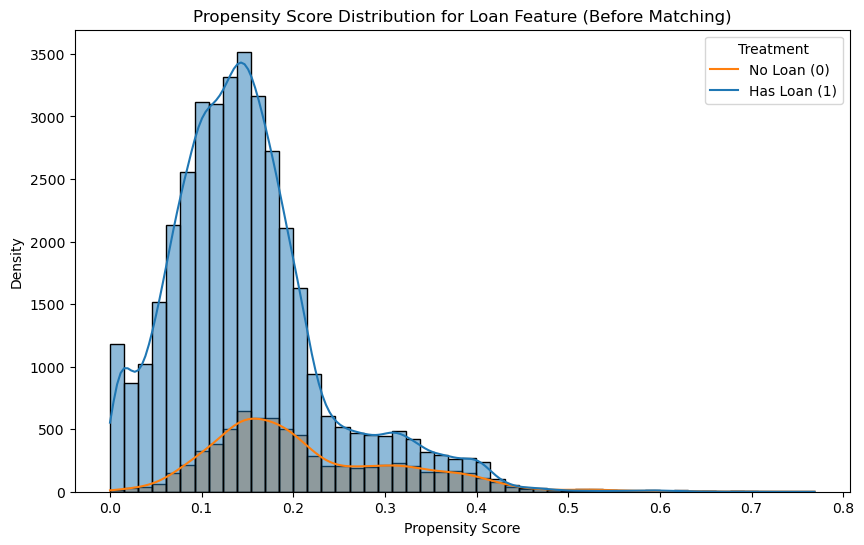

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


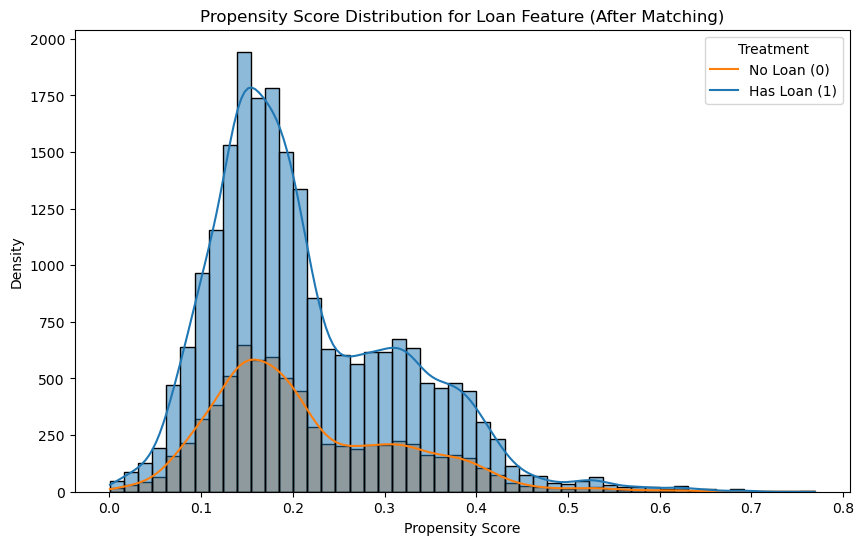

In [ ]:
# ✅ Before Matching
plt.figure(figsize=(10, 6))
sns.histplot(df, x="propensity_score_loan", hue="treatment", bins=50, kde=True)
plt.title("Propensity Score Distribution for Loan Feature (Before Matching)")
plt.xlabel("Propensity Score")
plt.ylabel("Density")
plt.legend(title="Treatment", labels=["No Loan (0)", "Has Loan (1)"])
plt.show()

# ✅ After Matching
plt.figure(figsize=(10, 6))
sns.histplot(balanced_df, x="propensity_score_loan", hue="treatment", bins=50, kde=True)
plt.title("Propensity Score Distribution for Loan Feature (After Matching)")
plt.xlabel("Propensity Score")
plt.ylabel("Density")
plt.legend(title="Treatment", labels=["No Loan (0)", "Has Loan (1)"])
plt.show()


In [7]:
from scipy.stats import ttest_ind

t_stat, p_value = ttest_ind(
    df[df['treatment'] == 1]['y'],
    df[df['treatment'] == 0]['y']
)

print(f"T-statistic: {t_stat}, P-value: {p_value}")


T-statistic: -14.53159987859371, P-value: 9.793657535354051e-48


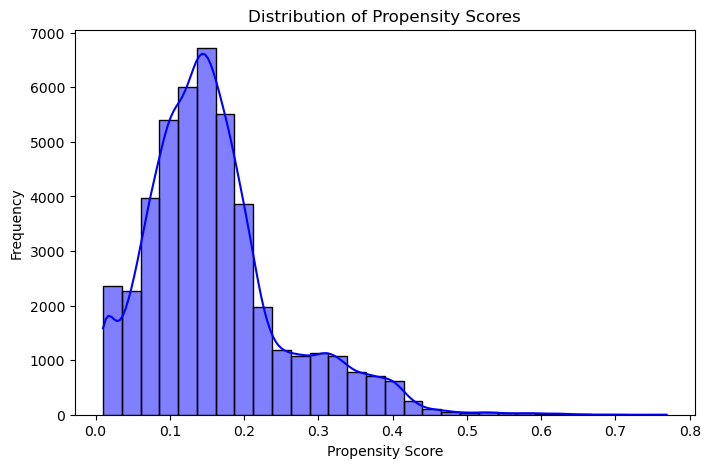

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

# ✅ Plot histogram of propensity scores
plt.figure(figsize=(8, 5))
sns.histplot(df['propensity_score_loan'], bins=30, kde=True, color='blue', edgecolor='black')

# ✅ Add labels
plt.xlabel('Propensity Score')
plt.ylabel('Frequency')
plt.title('Distribution of Propensity Scores')
plt.show()
